In [22]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
import os 
from warnings import simplefilter

In [23]:
import models
import class_sampling
import train
import metric_utils

In [24]:
NUM_CLASSES = 10
NUM_CLASSES_REDUCED = 2
n_epochs = 20
batch_size_train = 64
batch_size_test = 1000
momentum = 0

ratio = (10, 1)

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

nums = (0, 1)

CLASS_LABELS = {'airplane': 0,
                 'automobile': 1,
                 'bird': 2,
                 'cat': 3,
                 'deer': 4,
                 'dog': 5,
                 'frog': 6,
                 'horse': 7,
                 'ship': 8,
                 'truck': 9}



simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=UserWarning)
simplefilter(action='ignore', category=DeprecationWarning)

In [25]:
train_CIFAR10 = torchvision.datasets.CIFAR10('cifar10', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor() ]))  


test_CIFAR10 = torchvision.datasets.CIFAR10('cifar10', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()]))

train_CIFAR10.data = train_CIFAR10.data.reshape(50000, 3, 32, 32)
test_CIFAR10.data = test_CIFAR10.data.reshape(10000, 3, 32, 32)

    
reduced_train_CIFAR10 = class_sampling.Reduce(train_CIFAR10, NUM_CLASSES_REDUCED, nums=nums, CIFAR=True)
reduced_test_CIFAR10 = class_sampling.Reduce(test_CIFAR10, NUM_CLASSES_REDUCED, nums=nums, CIFAR=True)

ratio_train_CIFAR10 = class_sampling.BinaryRatio(train_CIFAR10, NUM_CLASSES_REDUCED, ratio, nums=nums,CIFAR=True)

Files already downloaded and verified
Files already downloaded and verified


In [26]:
train_loader_reduced = DataLoader(reduced_train_CIFAR10, batch_size=batch_size_train, shuffle=True) 

test_loader_reduced = DataLoader(reduced_test_CIFAR10, batch_size=batch_size_test, shuffle=True) 

train_loader_ratio = DataLoader(ratio_train_CIFAR10, batch_size=7000, shuffle=True)


Test set: Avg. loss: 0.001968830943107605, AUC: 0.6361665000000001


Test set: Avg. loss: 0.0006931712925434113, AUC: 0.5


Test set: Avg. loss: 0.0006931513249874115, AUC: 0.5


Test set: Avg. loss: 0.0006931595802307129, AUC: 0.5


Test set: Avg. loss: 0.0006931484639644623, AUC: 0.5


Test set: Avg. loss: 0.0006933614611625671, AUC: 0.5


Test set: Avg. loss: 0.000693147212266922, AUC: 0.5


Test set: Avg. loss: 0.0006932352185249329, AUC: 0.5


Test set: Avg. loss: 0.0006932772397994995, AUC: 0.5


Test set: Avg. loss: 0.0006931622624397278, AUC: 0.5


Test set: Avg. loss: 0.0006931504011154175, AUC: 0.5


Test set: Avg. loss: 0.0006931808292865753, AUC: 0.5


Test set: Avg. loss: 0.0006931629478931427, AUC: 0.5


Test set: Avg. loss: 0.0006931658983230591, AUC: 0.5


Test set: Avg. loss: 0.0006932205855846405, AUC: 0.5


Test set: Avg. loss: 0.0006931473016738892, AUC: 0.5


Test set: Avg. loss: 0.0006931476593017578, AUC: 0.5


Test set: Avg. loss: 0.0006934035122394561, AUC: 0.


Test set: Avg. loss: 0.0006932021975517273, AUC: 0.5


Test set: Avg. loss: 0.0006931551694869995, AUC: 0.5


Test set: Avg. loss: 0.0006931697428226471, AUC: 0.5


Test set: Avg. loss: 0.0006931588351726532, AUC: 0.5


Test set: Avg. loss: 0.0006931764185428619, AUC: 0.5


Test set: Avg. loss: 0.0006931509077548981, AUC: 0.5


Test set: Avg. loss: 0.0006934022605419159, AUC: 0.5


Test set: Avg. loss: 0.0006932594776153564, AUC: 0.5


Test set: Avg. loss: 0.0006931474804878234, AUC: 0.5


Test set: Avg. loss: 0.0006931505799293518, AUC: 0.5


Test set: Avg. loss: 0.0006931487619876861, AUC: 0.5


Test set: Avg. loss: 0.0006931553184986115, AUC: 0.5


Test set: Avg. loss: 0.0006931591331958771, AUC: 0.5


Test set: Avg. loss: 0.0006933353245258332, AUC: 0.5


Test set: Avg. loss: 0.0006931478679180146, AUC: 0.5


Test set: Avg. loss: 0.0006932533979415893, AUC: 0.5


Test set: Avg. loss: 0.0006931513249874115, AUC: 0.5


Test set: Avg. loss: 0.0006933068335056305, AUC: 0.5


Test set:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Test set: Avg. loss: 0.0006931709051132202, AUC: 0.5



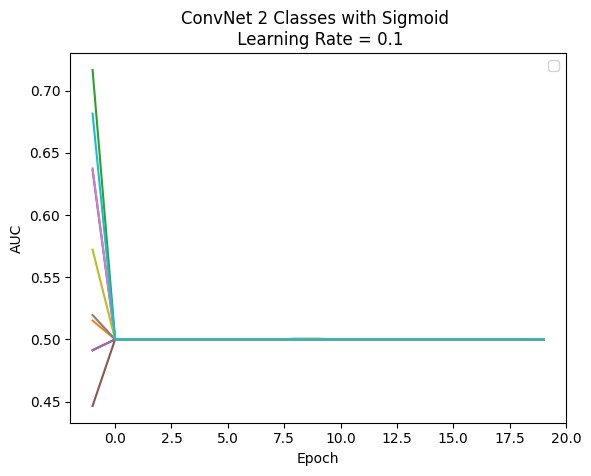


Test set: Avg. loss: 0.0029676575660705566, AUC: 0.301888


Test set: Avg. loss: 0.000693238079547882, AUC: 0.49850300000000003


Test set: Avg. loss: 0.0006929331123828888, AUC: 0.5000045


Test set: Avg. loss: 0.0006930451691150666, AUC: 0.501496


Test set: Avg. loss: 0.0006929251849651336, AUC: 0.5009975


Test set: Avg. loss: 0.0006929135918617249, AUC: 0.5009975


Test set: Avg. loss: 0.00069289830327034, AUC: 0.499501


Test set: Avg. loss: 0.000692875862121582, AUC: 0.499504


Test set: Avg. loss: 0.0006928536891937256, AUC: 0.5000005000000001


Test set: Avg. loss: 0.0006931636333465576, AUC: 0.4999995


Test set: Avg. loss: 0.0006931623220443726, AUC: 0.5000005


Test set: Avg. loss: 0.0006931498050689697, AUC: 0.499503


Test set: Avg. loss: 0.0006931722164154053, AUC: 0.4990035


Test set: Avg. loss: 0.0006931595802307129, AUC: 0.5000005000000001


Test set: Avg. loss: 0.0006931478083133698, AUC: 0.5000005000000001


Test set: Avg. loss: 0.0006931620240211487, AUC: 0.50049


Test set: Avg. loss: 0.0006931732892990112, AUC: 0.5


Test set: Avg. loss: 0.000693158745765686, AUC: 0.5


Test set: Avg. loss: 0.0006931518316268921, AUC: 0.5


Test set: Avg. loss: 0.0006931500732898713, AUC: 0.5


Test set: Avg. loss: 0.0006931487023830414, AUC: 0.5


Test set: Avg. loss: 0.000693147897720337, AUC: 0.5


Test set: Avg. loss: 0.0006931482553482056, AUC: 0.5


Test set: Avg. loss: 0.000693147212266922, AUC: 0.5


Test set: Avg. loss: 0.0006931471824645996, AUC: 0.5


Test set: Avg. loss: 0.0006931478679180146, AUC: 0.5


Test set: Avg. loss: 0.0006931488811969757, AUC: 0.5


Test set: Avg. loss: 0.0006931480765342712, AUC: 0.5


Test set: Avg. loss: 0.0006931474804878234, AUC: 0.5


Test set: Avg. loss: 0.0006931474208831788, AUC: 0.5


Test set: Avg. loss: 0.0006931472420692444, AUC: 0.5


Test set: Avg. loss: 0.0006931473016738892, AUC: 0.5


Test set: Avg. loss: 0.0006931477189064026, AUC: 0.5


Test set: Avg. loss: 0.004517494916915893, AUC: 0.394274


Test set

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Test set: Avg. loss: 0.0006931471824645996, AUC: 0.5



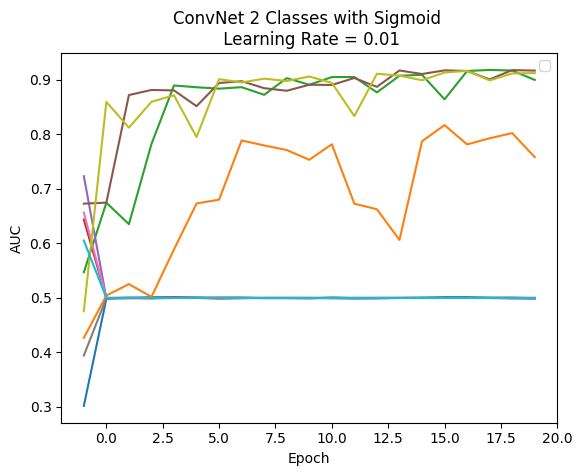


Test set: Avg. loss: 0.007872833013534546, AUC: 0.5021914999999999


Test set: Avg. loss: 0.0006664175987243652, AUC: 0.7028280000000001


Test set: Avg. loss: 0.0006650205850601196, AUC: 0.7198130000000003


Test set: Avg. loss: 0.000651433527469635, AUC: 0.781552


Test set: Avg. loss: 0.0006800925135612487, AUC: 0.6566425


Test set: Avg. loss: 0.0006473160684108734, AUC: 0.7911015


Test set: Avg. loss: 0.0006302227973937988, AUC: 0.8249420000000001


Test set: Avg. loss: 0.0006561740338802337, AUC: 0.7194725


Test set: Avg. loss: 0.0006708894073963165, AUC: 0.6964430000000001


Test set: Avg. loss: 0.0006130849421024323, AUC: 0.8388564999999999


Test set: Avg. loss: 0.0006187936961650849, AUC: 0.8238495


Test set: Avg. loss: 0.0006481800973415374, AUC: 0.7674764999999999


Test set: Avg. loss: 0.0006064464151859283, AUC: 0.8473470000000001


Test set: Avg. loss: 0.0006083714365959168, AUC: 0.8403419999999999


Test set: Avg. loss: 0.0006137407422065735, AUC: 0.8526905000000001


Test set: Avg. loss: 0.0006741491854190826, AUC: 0.655434


Test set: Avg. loss: 0.003675348162651062, AUC: 0.556548


Test set: Avg. loss: 0.0006946601569652557, AUC: 0.5240090000000001


Test set: Avg. loss: 0.0006945683360099793, AUC: 0.5147629999999999


Test set: Avg. loss: 0.0006932405531406403, AUC: 0.5797070000000001


Test set: Avg. loss: 0.0006933416724205018, AUC: 0.5702125


Test set: Avg. loss: 0.0006899519562721252, AUC: 0.5892745


Test set: Avg. loss: 0.0006842495799064636, AUC: 0.6494639999999999


Test set: Avg. loss: 0.0006750165224075317, AUC: 0.723526


Test set: Avg. loss: 0.0006329491436481476, AUC: 0.8196730000000001


Test set: Avg. loss: 0.0006114933490753174, AUC: 0.850264


Test set: Avg. loss: 0.0006093768477439881, AUC: 0.855229


Test set: Avg. loss: 0.000599500298500061, AUC: 0.875525


Test set: Avg. loss: 0.0005990504920482635, AUC: 0.8705765000000001


Test set: Avg. loss: 0.000573256641626358, AUC: 0.8888379999999999


Test set: Avg. loss: 0.0005636

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Test set: Avg. loss: 0.0006935488283634185, AUC: 0.499495



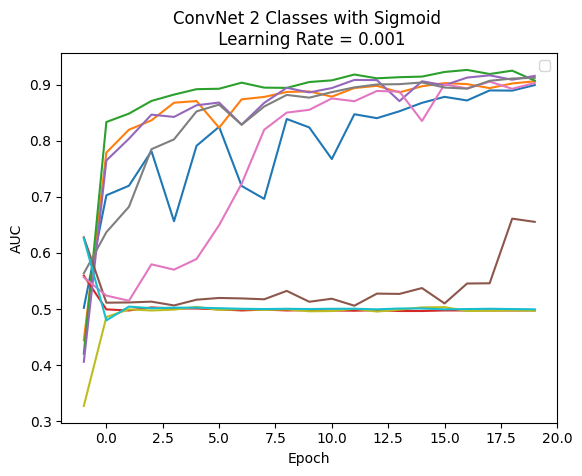


Test set: Avg. loss: 0.0012569047808647156, AUC: 0.676666


Test set: Avg. loss: 0.0006803757548332214, AUC: 0.6116385


Test set: Avg. loss: 0.0006800059378147125, AUC: 0.629924


Test set: Avg. loss: 0.000673571765422821, AUC: 0.654849


Test set: Avg. loss: 0.0006736795604228974, AUC: 0.655209


Test set: Avg. loss: 0.0006700741648674011, AUC: 0.6646469999999999


Test set: Avg. loss: 0.0006668732166290283, AUC: 0.6829299999999999


Test set: Avg. loss: 0.0006646293699741363, AUC: 0.6998154999999999


Test set: Avg. loss: 0.0006633379459381103, AUC: 0.7073685


Test set: Avg. loss: 0.0006584399342536927, AUC: 0.720461


Test set: Avg. loss: 0.0006569395363330841, AUC: 0.7269865000000001


Test set: Avg. loss: 0.000651640385389328, AUC: 0.7478695000000001


Test set: Avg. loss: 0.0006514511704444885, AUC: 0.7532580000000001


Test set: Avg. loss: 0.0006489593982696533, AUC: 0.762236


Test set: Avg. loss: 0.0006512028872966766, AUC: 0.7535270000000002


Test set: Avg. loss: 0.000646


Test set: Avg. loss: 0.0006858519315719604, AUC: 0.5810339999999999


Test set: Avg. loss: 0.0006789990067481994, AUC: 0.6150110000000001


Test set: Avg. loss: 0.0006759628057479858, AUC: 0.6455085000000002


Test set: Avg. loss: 0.0006711318492889404, AUC: 0.6740135


Test set: Avg. loss: 0.0006664163768291474, AUC: 0.6989725


Test set: Avg. loss: 0.0006641448140144348, AUC: 0.7094164999999997


Test set: Avg. loss: 0.0006538873016834259, AUC: 0.7300180000000001


Test set: Avg. loss: 0.0006673330664634705, AUC: 0.714322


Test set: Avg. loss: 0.0006518120765686035, AUC: 0.7537069999999999


Test set: Avg. loss: 0.0006392669975757599, AUC: 0.773013


Test set: Avg. loss: 0.000655323475599289, AUC: 0.7565990000000001


Test set: Avg. loss: 0.0006407658159732818, AUC: 0.7822975


Test set: Avg. loss: 0.0006465418934822083, AUC: 0.7812990000000002


Test set: Avg. loss: 0.0006319412589073181, AUC: 0.802099


Test set: Avg. loss: 0.0006219609975814819, AUC: 0.813844


Test set: Avg. lo

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Test set: Avg. loss: 0.0006933752000331879, AUC: 0.49990750000000006



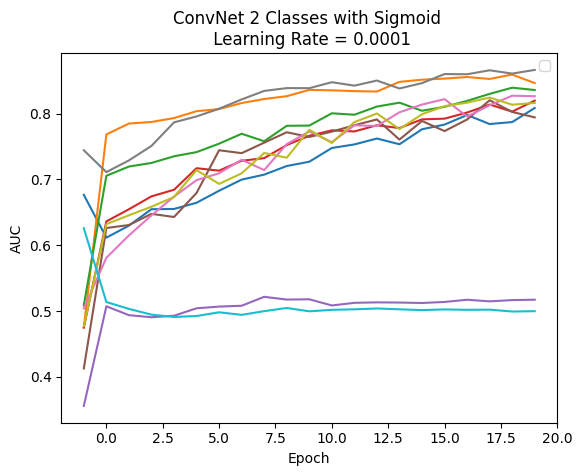


Test set: Avg. loss: 0.001783765971660614, AUC: 0.474386


Test set: Avg. loss: 0.0007646899819374085, AUC: 0.585949


Test set: Avg. loss: 0.0007067347466945648, AUC: 0.596346


Test set: Avg. loss: 0.0006976052820682526, AUC: 0.570744


Test set: Avg. loss: 0.0006957734227180481, AUC: 0.562446


Test set: Avg. loss: 0.0006972709000110626, AUC: 0.545744


Test set: Avg. loss: 0.0006957111060619354, AUC: 0.543722


Test set: Avg. loss: 0.000694058746099472, AUC: 0.54207


Test set: Avg. loss: 0.0006944672763347626, AUC: 0.5382855


Test set: Avg. loss: 0.0006935897767543792, AUC: 0.539559


Test set: Avg. loss: 0.0006940735280513763, AUC: 0.5286545


Test set: Avg. loss: 0.0006927105784416198, AUC: 0.537864


Test set: Avg. loss: 0.000693018227815628, AUC: 0.534075


Test set: Avg. loss: 0.0006930310726165771, AUC: 0.530082


Test set: Avg. loss: 0.0006926904618740082, AUC: 0.5304560000000001


Test set: Avg. loss: 0.0006912394464015961, AUC: 0.5460825


Test set: Avg. loss: 0.0006896


Test set: Avg. loss: 0.0007102650105953217, AUC: 0.509282


Test set: Avg. loss: 0.000710315078496933, AUC: 0.491101


Test set: Avg. loss: 0.0007089231014251709, AUC: 0.480842


Test set: Avg. loss: 0.0007075543105602264, AUC: 0.478622


Test set: Avg. loss: 0.000706177294254303, AUC: 0.4717275


Test set: Avg. loss: 0.0007049018144607544, AUC: 0.47392549999999994


Test set: Avg. loss: 0.0007035290002822876, AUC: 0.4743335


Test set: Avg. loss: 0.0007025107741355896, AUC: 0.4776255


Test set: Avg. loss: 0.0007018645107746125, AUC: 0.4764125


Test set: Avg. loss: 0.0007012608349323273, AUC: 0.47833200000000003


Test set: Avg. loss: 0.0007007564008235931, AUC: 0.48122


Test set: Avg. loss: 0.0007003094553947449, AUC: 0.4773800000000001


Test set: Avg. loss: 0.0006999156475067139, AUC: 0.4713735


Test set: Avg. loss: 0.0006996125280857086, AUC: 0.47473599999999994


Test set: Avg. loss: 0.0006992958784103393, AUC: 0.47602400000000006


Test set: Avg. loss: 0.000699061930179596, 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Test set: Avg. loss: 0.0006752201020717621, AUC: 0.6460794999999999



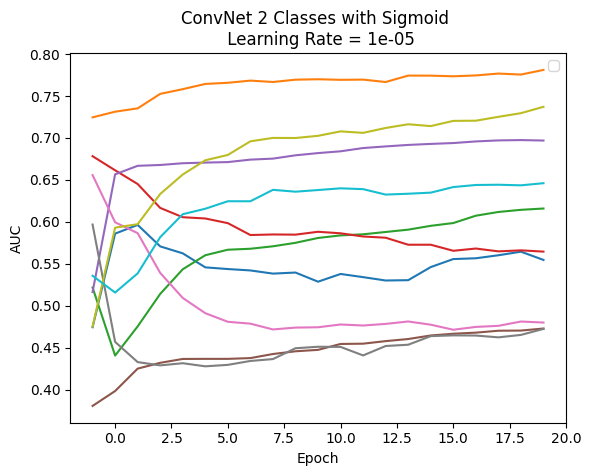


Test set: Avg. loss: 0.0016581254005432128, AUC: 0.4479535


Test set: Avg. loss: 0.0013822515606880187, AUC: 0.45977750000000006


Test set: Avg. loss: 0.001221610963344574, AUC: 0.46709500000000004


Test set: Avg. loss: 0.0011222146153450011, AUC: 0.472287


Test set: Avg. loss: 0.0010552871227264404, AUC: 0.47553300000000004


Test set: Avg. loss: 0.0010123384594917298, AUC: 0.478564


Test set: Avg. loss: 0.0009772454500198363, AUC: 0.48080950000000006


Test set: Avg. loss: 0.0009486221075057983, AUC: 0.483638


Test set: Avg. loss: 0.0009250609874725342, AUC: 0.48616800000000004


Test set: Avg. loss: 0.0009042295515537262, AUC: 0.48874900000000004


Test set: Avg. loss: 0.0008868124186992646, AUC: 0.49076899999999996


Test set: Avg. loss: 0.0008714881539344788, AUC: 0.493325


Test set: Avg. loss: 0.0008570928871631622, AUC: 0.495617


Test set: Avg. loss: 0.0008463151156902313, AUC: 0.497155


Test set: Avg. loss: 0.0008356136679649353, AUC: 0.4989


Test set: Avg. loss: 0.0


Test set: Avg. loss: 0.0011588422656059266, AUC: 0.469131


Test set: Avg. loss: 0.001117954730987549, AUC: 0.474122


Test set: Avg. loss: 0.0010785470604896545, AUC: 0.47704750000000007


Test set: Avg. loss: 0.0010422364473342896, AUC: 0.478021


Test set: Avg. loss: 0.0010046719908714293, AUC: 0.479127


Test set: Avg. loss: 0.0009678251147270203, AUC: 0.480463


Test set: Avg. loss: 0.0009419669806957245, AUC: 0.480151


Test set: Avg. loss: 0.000917037844657898, AUC: 0.481735


Test set: Avg. loss: 0.0008969317078590393, AUC: 0.482638


Test set: Avg. loss: 0.0008804025948047638, AUC: 0.483883


Test set: Avg. loss: 0.0008648879826068878, AUC: 0.485526


Test set: Avg. loss: 0.0008521326780319214, AUC: 0.48618000000000006


Test set: Avg. loss: 0.000838062047958374, AUC: 0.488985


Test set: Avg. loss: 0.0008258811831474304, AUC: 0.491165


Test set: Avg. loss: 0.0008129096925258637, AUC: 0.495057


Test set: Avg. loss: 0.0007996936440467834, AUC: 0.499819


Test set: Avg. loss:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Test set: Avg. loss: 0.0007440287172794342, AUC: 0.5004725



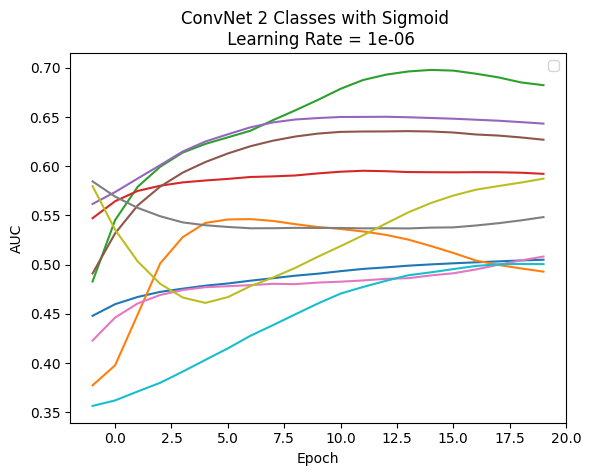


Test set: Avg. loss: 0.0009661920666694642, AUC: 0.631116


Test set: Avg. loss: 0.0009607993662357331, AUC: 0.6305459999999999


Test set: Avg. loss: 0.0009551736116409302, AUC: 0.630061


Test set: Avg. loss: 0.0009496512711048126, AUC: 0.629488


Test set: Avg. loss: 0.0009455106258392334, AUC: 0.628903


Test set: Avg. loss: 0.0009413460493087768, AUC: 0.628323


Test set: Avg. loss: 0.0009382360279560089, AUC: 0.6277079999999999


Test set: Avg. loss: 0.0009331867694854736, AUC: 0.627332


Test set: Avg. loss: 0.0009289628267288208, AUC: 0.6268670000000001


Test set: Avg. loss: 0.0009243561327457428, AUC: 0.626414


Test set: Avg. loss: 0.0009199171662330627, AUC: 0.6257699999999999


Test set: Avg. loss: 0.0009158753454685211, AUC: 0.625224


Test set: Avg. loss: 0.0009103074073791504, AUC: 0.6247240000000001


Test set: Avg. loss: 0.0009057278335094452, AUC: 0.6240889999999999


Test set: Avg. loss: 0.0009014009237289428, AUC: 0.6234985


Test set: Avg. loss: 0.000896499365568


Test set: Avg. loss: 0.002244644284248352, AUC: 0.433143


Test set: Avg. loss: 0.0022026073932647707, AUC: 0.434878


Test set: Avg. loss: 0.0021687995195388793, AUC: 0.43855200000000005


Test set: Avg. loss: 0.0021303905248641966, AUC: 0.441498


Test set: Avg. loss: 0.002093176245689392, AUC: 0.444978


Test set: Avg. loss: 0.0020573221445083618, AUC: 0.44902899999999996


Test set: Avg. loss: 0.0020208367109298708, AUC: 0.4538255


Test set: Avg. loss: 0.001986502289772034, AUC: 0.4586720000000001


Test set: Avg. loss: 0.0019543298482894897, AUC: 0.464436


Test set: Avg. loss: 0.0019169955253601075, AUC: 0.46925999999999995


Test set: Avg. loss: 0.0018746912479400634, AUC: 0.472438


Test set: Avg. loss: 0.001836487650871277, AUC: 0.476701


Test set: Avg. loss: 0.0017951215505599975, AUC: 0.480008


Test set: Avg. loss: 0.0017600381374359131, AUC: 0.48459


Test set: Avg. loss: 0.001721031665802002, AUC: 0.487869


Test set: Avg. loss: 0.0016842177510261536, AUC: 0.4917425




In [ ]:
# SIGMOID 2 CLASS 

momentum=0
learning_rates = [0.1, 0.01, 0.001, 0.0001, 1e-5, 1e-6, 1e-7]

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.ConvNet(NUM_CLASSES_REDUCED)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_sigmoid(epoch, train_loader_reduced, network, optimizer, verbose=False)
            _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network)
            model_aucs.append(auc)
        aucs.append(model_aucs)
        plt.plot(np.arange(-1, n_epochs), aucs[i])
    plt.title("ConvNet 2 Classes with Sigmoid \n Learning Rate = " + str(learning_rate))
    plt.xlabel("Epoch")
    plt.ylabel("AUC")
    plt.legend()
    plt.show()
   

In [ ]:
# SOFTMAX 2 CLASS 

momentum=0
learning_rates = [0.1, 0.01, 0.001, 0.0001, 1e-5, 1e-6, 1e-7]

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.ConvNet(NUM_CLASSES_REDUCED)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_softmax(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_softmax(epoch, train_loader_reduced, network, optimizer, verbose=False)
            _, auc = metric_utils.auc_softmax(test_loader_reduced, network)
            model_aucs.append(auc)
        aucs.append(model_aucs)
        plt.plot(np.arange(-1, n_epochs), aucs[i])
    plt.title("ConvNet 2 Classes with Softmax \n Learning Rate = " + str(learning_rate))
    plt.xlabel("Epoch")
    plt.ylabel("AUC")
    plt.legend()
    plt.show()

In [8]:
# SIGMOID 2 CLASS RATIO


learning_rates = [0.1, 0.01, 0.001, 0.0001, 1e-5, 1e-6, 1e-7]

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.ConvNet(NUM_CLASSES_REDUCED)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network) 
        print(y_preds)
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_sigmoid(epoch, train_loader_ratio, network, optimizer, verbose=False)
            _, auc = metric_utils.auc_sigmoid(test_loader_reduced, network)
            model_aucs.append(auc)
        aucs.append(model_aucs)
        plt.plot(np.arange(-1, n_epochs), aucs[i])
    plt.title("ConvNet 2 Classes " + str(ratio) + " with Sigmoid \n Learning Rate = " + str(learning_rate))
    plt.xlabel("Epoch")
    plt.ylabel("AUC")
    plt.legend()
    plt.show()
   


Test set: Avg. loss: 0.0034114049673080443, AUC: 0.5598955000000001



NameError: name 'run_inference_sigmoid' is not defined

In [ ]:
# SOFTMAX 2 CLASS RATIO


learning_rates = [0.1, 0.01, 0.001, 0.0001, 1e-5, 1e-6, 1e-7]

for learning_rate in learning_rates:
    aucs = []
    for i in range(10):
        model_aucs = []
        network = models.ConvNet(NUM_CLASSES_REDUCED)
        optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        _, auc = metric_utils.auc_softmax(test_loader_reduced, network) 
        model_aucs.append(auc)
        for epoch in range(n_epochs):
            _, _ = train.train_softmax(epoch, train_loader_ratio, network, optimizer, verbose=False)
            _, auc = metric_utils.auc_softmax(test_loader_reduced, network)
            model_aucs.append(auc)
        aucs.append(model_aucs)
        plt.plot(np.arange(-1, n_epochs), aucs[i])
    plt.title("ConvNet 2 Classes " + str(ratio) + " with Softmax \n Learning Rate = " + str(learning_rate))
    plt.xlabel("Epoch")
    plt.ylabel("AUC")
    plt.legend()
    plt.show()
   